<img src="https://raw.githubusercontent.com/EO-College/cubes-and-clouds/main/icons/cnc_3icons_share_cirlce.svg"
     alt="Cubes & Clouds logo"
     style="float: center; margin-right: 10px;" />

# 3.4 Data Sharing
Science is much more impactful once it's shared. Therefore, we are going to learn how to 
open up our scientific output from a cloud platform, so that is openly available - and 
has the chance to make the impact it should.
- Reuse the workflow we have used before for creating the snow covered area
- Select AOI,
- Recreate process graph, 
- Download results for one time-step
  - A Snow Cover Area map in the COG format
  - A STAC metadata item that is provided with the result from openEO at CDSE
- Adapt the STAC item
- Upload the results and make them available openly via a STAC browser and web map


## Libraries

In [1]:
import json

import openeo
import numpy as np
import leafmap

import geopandas as gpd
import shapely
from shapely.geometry import Polygon

import rioxarray as rio
import xarray

Import utility functions

In [2]:
%run cubes_utilities.py

## Login

Connect to the copernicus dataspace ecosystem.

In [3]:
conn = openeo.connect('https://openeo.dataspace.copernicus.eu/')

Authenticate login

In [4]:
conn.authenticate_oidc()

Authenticated using refresh token.


<Connection to 'https://openeo.dataspace.copernicus.eu/openeo/1.2/' with OidcBearerAuth>

Check if the login worked

In [ ]:
conn.describe_account()

## Select an Area of Interest and Time Frame
Start by selecting a center point of the area you would like to analyse from the map shown below. Create a 1 km bounding box around it. This will be the area you are calculating the snow covered area for. Make sure not to overlap too much with already mapped areas. It's a community mapping project :)

In [6]:
m = leafmap.Map(center=(46.497012, 11.356429), zoom=14)
m

Map(center=[46.497012, 11.356429], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title',…

In [7]:
feat = m.draw_features
geom = feat[0]['geometry']['coordinates']

In [8]:
distance_km = 1
# Create a bounding box around the point
bbox = create_bounding_box(geom[0], geom[1], distance_km)
visualize_bbox(m, bbox)

Now we'll select the time frame. We'll start with the winter months of 2023. 

In [ ]:
temporal_extent = ["2023-02-01", "2023-06-01"]

## Reuse the process graph of the snow covered area data cube
We've saved the python code that we had used to create the snow cover area data cube into a python function `calculate_sca()`. It's stored in `cubes_utilities.py`. It creates a 4 dimensional data cube with the dimensions: x, y, time, bands.
As parameters we have exposed the bounding box and temporal extent. We will update them with the choices we have made above. 

In [9]:
snow_map_4dcube = calculate_sca(conn, bbox, temporal_extent)
snow_map_4dcube

## Reduce the time dimension
We want to calculate the SCA for the winter period of a given year. Therefore, we need to reduce the values along the time dimension. We'll use the process `reduce_dimension()` with a `median()` to accomplish this. We are directly continuing to build on our process graph that we have loaded above.

In [10]:
snow_map_3dcube = snow_map_4dcube.reduce_dimension(reducer="median", dimension="t")
snow_map_3dcube

## Download result
To finish our process graph we add the `save_result()` process choosing the `GTiff` format. It creates a COG out of the box with openEO on CDSE.

In [11]:
# create a batch job
snowmap_cog = snow_map_3dcube.save_result(format = "GTiff") #, options = {"overviews": "AUTO"})

We register the job as a batch job on the backend and start the processing.

In [12]:
job = snowmap_cog.create_job(title="snowmap_cog")
job.start_job()

Let's check the status of the job.

In [14]:
job.status()

'finished'

Now let's wait until the job is finished and then download the results.

In [15]:
if job.status() == "finished":
    results = job.get_results()
    results.download_files("results/")

## Load results
Now we can open the COG and visualize it.

In [16]:
snowmap = rio.open_rasterio("results/openEO.tif",decode_coords="all")
snowmap

<xarray.DataArray (band: 1, y: 209, x: 145)>
[30305 values with dtype=float32]
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 6.838e+05 6.838e+05 ... 6.852e+05 6.852e+05
  * y            (y) float64 5.157e+06 5.157e+06 ... 5.155e+06 5.155e+06
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:        Area
    PROCESSING_SOFTWARE:  0.19.6a1
    _FillValue:           nan
    scale_factor:         1.0
    add_offset:           0.0

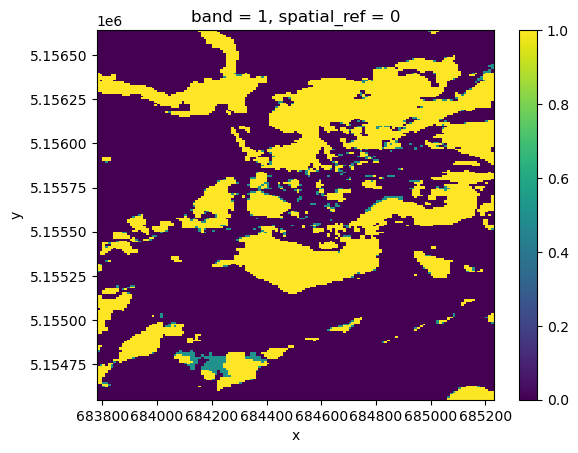

In [17]:
snowmap.plot()

## Load STAC metadata
In addition to the COG we also receive STAC metadata for our result.
Let's have a look at it.

In [18]:
stac_collection = results.get_metadata()

In [3]:
import json
with open("results/stac_item.json") as f:
    stac_collection = json.load(f)

In [4]:
stac_collection

{'assets': {'openEO.tif': {'file:nodata': ['nan'],
   'href': 'https://openeo.dataspace.copernicus.eu/openeo/1.1/jobs/j-2311159d5c19419e97f9cd204828b161/results/assets/MDYxODNjYmMtODRjOC00YzZhLThhN2QtY2IxOGJhMDhjYzhj/d19e802d03e5e47b3e2b9556bee79313/openEO.tif?expires=1700646046',
   'proj:bbox': [683720.0, 5154640.0, 685170.0, 5156730.0],
   'proj:epsg': 32632,
   'proj:shape': [145, 209],
   'raster:bands': [{'name': '1',
     'statistics': {'maximum': 1.0,
      'mean': 0.26924599901006,
      'minimum': 0.0,
      'stddev': 0.43847078952239,
      'valid_percent': 100.0}}],
   'roles': ['data'],
   'title': 'openEO.tif',
   'type': 'image/tiff; application=geotiff'}},
 'description': 'Results for batch job j-2311159d5c19419e97f9cd204828b161',
 'extent': {'spatial': {'bbox': [[11.396102783940814,
     46.520292622936324,
     11.414089216059187,
     46.53864137706367]]},
  'temporal': {'interval': [['2018-01-01T00:00:00Z',
     '2018-02-15T00:00:00Z']]}},
 'id': 'j-2311159d5c19419e

### Adding Author of the data

Add you information to become visible as author of the data -  description of each field can be found here: https://github.com/radiantearth/stac-spec/blob/master/item-spec/common-metadata.md#provider-object

Please note that leaving the field empty will lead to failed validation of STAC item

In [45]:
author = [{
    "name": "",
    "description": "",
    "roles": ["processor"],
}]

providers = stac_collection["providers"] + author

Creating actual polygon geometry from previously created bbox information

In [31]:
min_x, min_y, max_x, max_y = stac_collection["extent"]["spatial"]["bbox"][0]
geometry = {
    "type": "Polygon",
    "coordinates": [[
        [min_x, min_y],
        [max_x, min_y],
        [max_x, max_y],
        [min_x, max_y],
        [min_x, min_y]
    ]]
}


Let's create the actual STAC item describing your data! As talked about in previous lessons, STAC item has various required fields which need to be present and filled correctly

In [108]:
stac_item = {
    "type": "Feature", 
    "stac_version": stac_collection["stac_version"],
    "stac_extensions": [],
    "id": stac_collection["id"],
    "geometry": geometry,
    "bbox": stac_collection["extent"]["spatial"]["bbox"][0],
    
    "properties": {
       "datetime": None, 
        "start_datetime": stac_collection["extent"]["temporal"]["interval"][0][0],
        "end_datetime": stac_collection["extent"]["temporal"]["interval"][0][1],
        "providers" : providers
                 },
    
    "links": stac_collection["links"],
    "assets": {"visual": {
      "href": "openEO.tif",
      "type": "image/tiff; application=geotiff; profile=cloud-optimized",
      "title": "Snow coverage",
      "roles": [
        "data"
              ]
            }
        },
}

In [90]:
stac_item

{'type': 'Feature',
 'stac_version': '1.0.0',
 'stac_extensions': ['https://stac-extensions.github.io/eo/v1.1.0/schema.json',
  'https://stac-extensions.github.io/file/v2.1.0/schema.json',
  'https://stac-extensions.github.io/processing/v1.1.0/schema.json',
  'https://stac-extensions.github.io/projection/v1.1.0/schema.json'],
 'id': 'j-2311159d5c19419e97f9cd204828b161',
 'geometry': {'type': 'Polygon',
  'coordinates': [[[11.396102783940814, 46.520292622936324],
    [11.414089216059187, 46.520292622936324],
    [11.414089216059187, 46.53864137706367],
    [11.396102783940814, 46.53864137706367],
    [11.396102783940814, 46.520292622936324]]]},
 'bbox': [11.396102783940814,
  46.520292622936324,
  11.414089216059187,
  46.53864137706367],
 'properties': {'datetime': None,
  'start_datetime': '2018-01-01T00:00:00Z',
  'end_datetime': '2018-02-15T00:00:00Z'},
 'links': [{'href': '/eodata/Sentinel-2/MSI/L2A/2018/01/02/S2A_MSIL2A_20180102T102421_N9999_R065_T32TPS_20221108T215439',
   'rel':

Saving the resulting item as stac_item.json into results folder

In [109]:
stac_json = json.dumps(stac_item)
with open("results/stac_item.json", "w") as file:
    file.write(stac_json)

Validating that STAC item is important - non valid STAC will not be displayed in the STAC browser after upload

In [110]:
from stac_validator import stac_validator
import requests
stac = stac_validator.StacValidate()
f = open('results/stac_item.json')
data = json.load(f)
stac.validate_dict(data)
print(stac.message)

[{'version': '1.0.0', 'path': None, 'schema': ['https://schemas.stacspec.org/v1.0.0/item-spec/json-schema/item.json'], 'valid_stac': True, 'asset_type': 'ITEM', 'validation_method': 'default'}]


### Now it is time to upload solution to the submission folder and make results visible in STAC browser

Upload both STAC json file and final .tif file to "submissions" folder in your home directory

You can use code bellow ot copy the code for you - if your results are stored at different path, you need to modify the path correctly

In [ ]:
!cp ./results/stac_item.json submissions/
!cp ./results/openEO.tif submissions/

And now by executing the cell bellow, update of the STAC browser will start. 

In [112]:
env_var1 = os.getenv('EMAIL')
curl_command = f"curl -X POST -F token=glptt-42d31ac6f592a9e321d0e4877e654dc50dcf4854 -F ref=main -F 'variables[USER_DIRECTORY]=\"{env_var1}\"' https://gitlab.eox.at/api/v4/projects/554/trigger/pipeline" 
process = subprocess.Popen(curl_command, shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
stdout, stderr = process.communicate()

You can now browse your results inside the Catalog! And verified that you are correctly listed as a provider.

https://esa.pages.eox.at/cubes-and-clouds-catalog/browser/#/?.language=en

If you would like to redo your submission, you can still update your files in submissions folder and once ready, run again the code in the cell above

Happy coding!